In [1]:
# Importing of necessary libraries
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # <-- import colormaps
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

# Loading of Excel file
excel_file = pd.read_excel('Twisto_data.xlsx', sheet_name=None)

In [2]:
# Extracting of individual DataFrames
df_base = excel_file['profile_base']
df_customer = excel_file['profile_customer']
df_extension = excel_file['profile_extension']
df_apps = excel_file['profile_apps']
df_transactions = excel_file['profile_transactions']

In [3]:
# Cleaning up df_base (1st sheet)
# Fixing specific incorrect dates
df_base['date_upgraded'] = df_base['date_upgraded'].replace({
    '2090-10-12 09:55:36.000': '2014-10-12 09:55:36.000',
    '2080-12-23 22:50:47.000': '2015-12-23 22:50:47.000'
})

# Convert to datetime
df_base['date_upgraded'] = pd.to_datetime(df_base['date_upgraded'], errors='coerce')

# Create separate date and time columns (only hours & minutes)
df_base['date_upgr'] = df_base['date_upgraded'].dt.date
df_base['time_upgr'] = df_base['date_upgraded'].dt.strftime('%H:%M')

# Drop the original datetime column
df_base.drop(columns=['date_upgraded'], inplace=True)

# Strip leading/trailing spaces
df_base['source'] = df_base['source'].str.strip()

# Replace specific typos
df_base['source'] = df_base['source'].replace({
    'now saved card': 'now',
    'now': 'now',  # redundant but keeps structure clear
    'referrall': 'referral',
    'affill': 'affiliate',
    'affil': 'affiliate'
})

In [4]:
# Cleaning up df_customer (2nd sheet)
# Clean 'gender' column: Replace 99 with 'Unknown' or a proper missing value
df_customer['gender'] = df_customer['gender'].replace(99, 'Unknown')

# Filling/replacing missing values in other columns with 'Unknown'
df_customer['education_type'] = df_customer['education_type'].fillna('Unknown')
df_customer['family_children'] = df_customer['family_children'].fillna('Unknown')
df_customer['family_children'] = df_customer['family_children'].fillna('Unknown')
df_customer['family_children'] = df_customer['family_children'].replace('-100', 'Unknown')

# Normalize 'education_type': Replace 'Secondary with exam' with 'Secondary'
df_customer['education_type'] = df_customer['education_type'].replace('Secondary with exam', 'Secondary')

# Convert 'family_children' to numeric where possible, errors='coerce' will convert 'Unknown'
df_customer['family_children_num'] = pd.to_numeric(df_customer['family_children'], errors='coerce')

# Create 'family_size' column based on conditions
def family_size_label(x):
    if pd.isna(x):  # this corresponds to 'Unknown' or missing values
        return 'No children'
    elif x == 0:
        return 'No children'
    elif x == 1:
        return 'One children'
    elif x > 1:
        return 'Big family'

df_customer['family_size'] = df_customer['family_children_num'].apply(family_size_label)

# Dropping the helper numeric column
df_customer.drop(columns=['family_children_num'], inplace=True)

In [5]:
# Adding the column 'age_at_joining' in the df_customer
# Ensure datetime conversion
df_customer['date_of_birth'] = pd.to_datetime(df_customer['date_of_birth'], errors='coerce')
df_base['date_upgr'] = pd.to_datetime(df_base['date_upgr'], errors='coerce')

# Merge FULL dataframes on "user"
df_cmr = pd.merge(
    df_customer,
    df_base,
    on='user',
    how='left',   # keep all customers, even if not in df_base
    suffixes=('_cust', '_base')
)

# Calculate 'age' at joining
df_cmr['age'] = (
    (df_cmr['date_upgr'] - df_cmr['date_of_birth']).dt.days // 365
)

In [6]:
# Basic checking of number from the file
total_customers = len(df_customer)
male_customers = df_customer[df_customer['gender'].str.lower() == 'male'].shape[0]
female_customers = df_customer[df_customer['gender'].str.lower() == 'female'].shape[0]
unknown_gender = df_customer[df_customer['gender'].str.lower() == 'unknown'].shape[0]
average_age = df_cmr['age'].dropna().mean()
total_transactions = len(df_transactions)
ios_users_count = df_apps[df_apps['app_ios'] > 0]['user'].nunique()
android_users_count = df_apps[df_apps['app_android'] > 0]['user'].nunique()


print(f"Total customers: {total_customers}")
print(f"Male customers: {male_customers}")
print(f"Female customers: {female_customers}")
print(f"Unknown gender customers: {unknown_gender}")
print(f"Average age: {average_age:.2f} years")
print(f"Total transactions: {total_transactions}")
print(f"Number of iOS users: {ios_users_count}")
print(f"Number of Android users: {android_users_count}")

Total customers: 1009
Male customers: 526
Female customers: 468
Unknown gender customers: 15
Average age: 31.34 years
Total transactions: 67267
Number of iOS users: 292
Number of Android users: 314


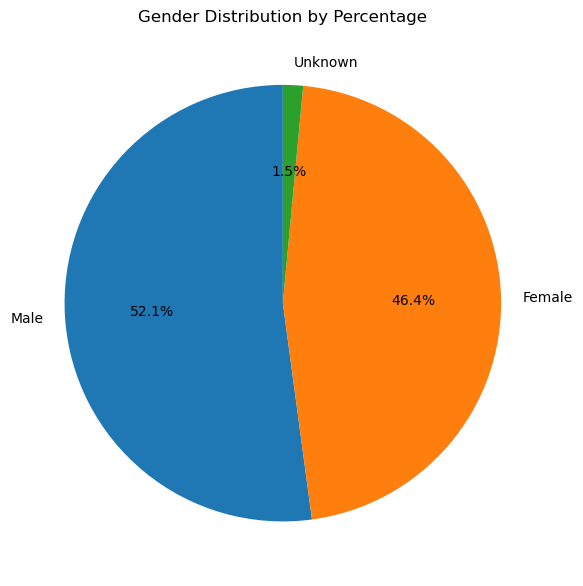

In [7]:
%matplotlib inline
# Gender distribution
gender_counts = df_cmr['gender'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Gender Distribution by Percentage")
plt.tight_layout()
plt.show()


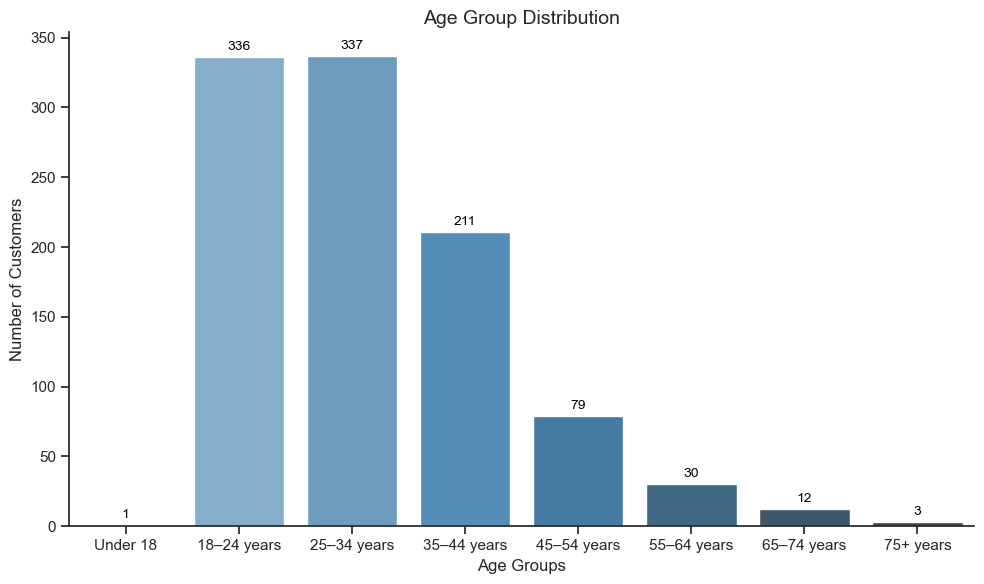

In [8]:
# Seaborn theme
sns.set_theme(style="ticks", palette="dark:b_r")

# Define age bins and friendly labels
bins = [0, 18, 25, 35, 45, 55, 65, 75, 100]
labels = [
    "Under 18",
    "18–24 years",
    "25–34 years",
    "35–44 years",
    "45–54 years",
    "55–64 years",
    "65–74 years",
    "75+ years"
]

# Create age groups
df_cmr['age_group'] = pd.cut(df_cmr['age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10,6))
ax = sns.countplot(
    data=df_cmr,
    x='age_group',
    hue='age_group',
    order=labels,
    palette='Blues_d',
    legend=False
)

# Formatting
plt.title("Age Group Distribution", fontsize=14)
plt.xlabel("Age Groups", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

# Remove top and right borders
sns.despine(top=True, right=True)

# Show counts on top of bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(
        f'{height}',  
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', fontsize=10, color='black', xytext=(0,3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

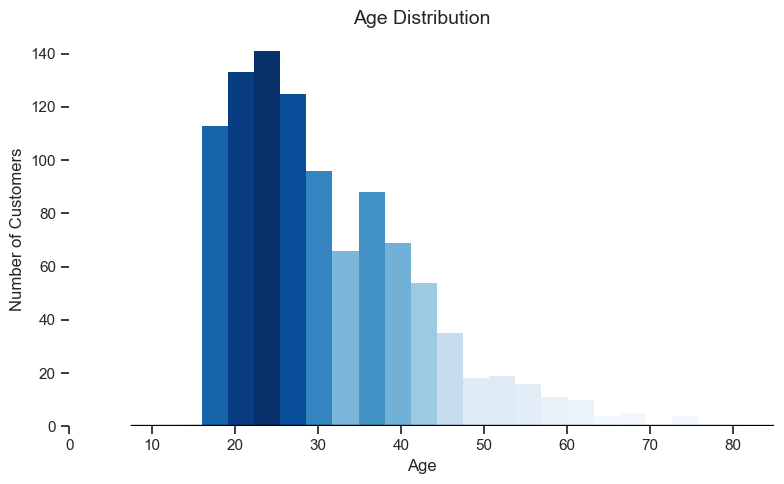

In [9]:
plt.figure(figsize=(8,5))

# Get histogram data first
counts, bins = np.histogram(df_cmr['age'].dropna(), bins=20)

# Normalize counts for color mapping
norm = plt.Normalize(counts.min(), counts.max())
cmap = plt.cm.Blues  # choose gradient colormap

# Draw bars manually with gradient colors
for i in range(len(counts)):
    plt.bar(
        bins[i], counts[i], 
        width=(bins[i+1]-bins[i]),
        align='edge',
        color=cmap(norm(counts[i])),
        edgecolor='none'
    )

# Add KDE curve
sns.kdeplot(df_cmr['age'].dropna(), color='black', lw=2)

# Titles & labels
plt.title("Age Distribution", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

# Limit x-axis to 85 years
plt.xlim(0, 85)

# Remove all spines (frame)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.tight_layout()
plt.show()


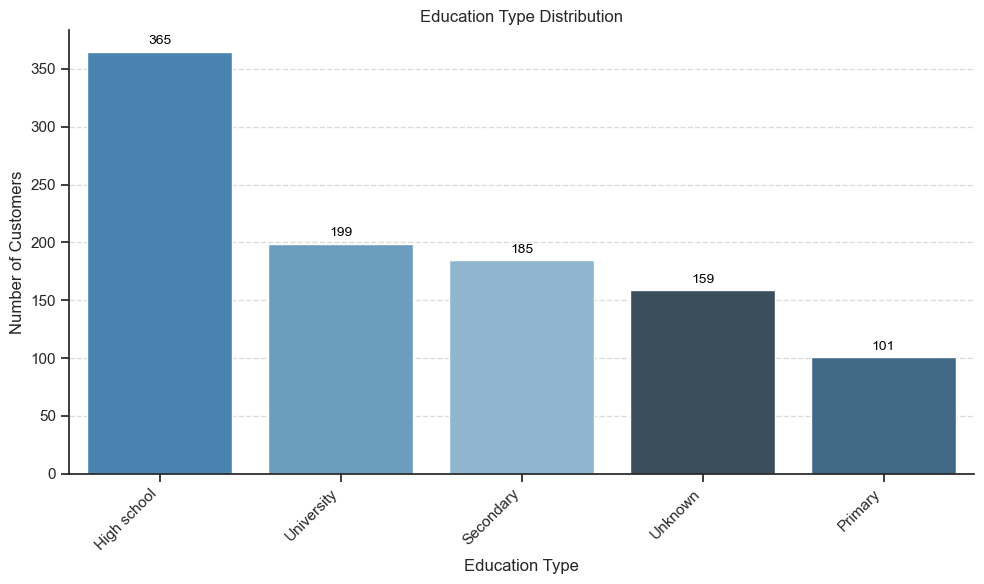

In [10]:
sns.set_theme(style="ticks", palette="dark:b_r")
plt.figure(figsize=(10,6))

ax = sns.countplot(
    data=df_cmr,
    x="education_type",
    hue="education_type",
    order=df_cmr['education_type'].value_counts().index,
    palette="Blues_d",
    legend=False
)

# Titles & labels
plt.title("Education Type Distribution", fontsize=12)
plt.xlabel("Education Type", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Add horizontal grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top/right spines
sns.despine(top=True, right=True)

# Show counts above bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f'{count}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0,3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

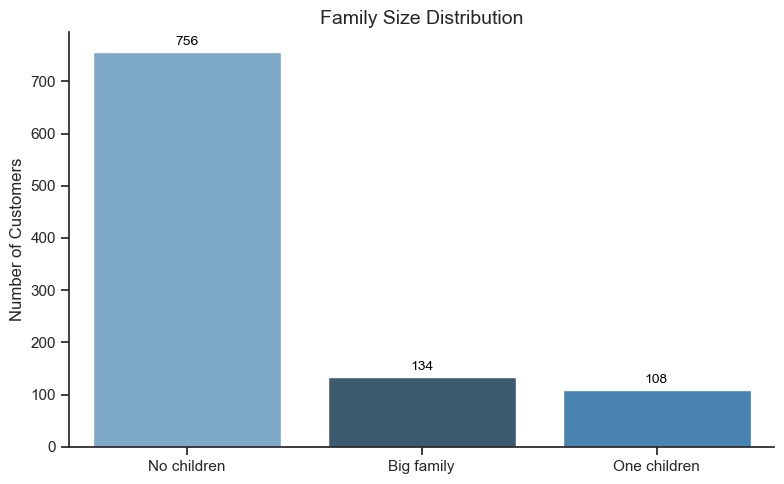

In [11]:
plt.figure(figsize=(8,5))

# Countplot for family_size
ax = sns.countplot(
    data=df_cmr,
    x="family_size",
    order=df_cmr['family_size'].value_counts().index,  # sort by frequency
    palette="Blues_d",
    hue="family_size",  # for palette
    legend=False        # hide legend
)

# Titles & labels
plt.title("Family Size Distribution", fontsize=14)
plt.xlabel("", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

# Remove top/right spines
sns.despine(top=True, right=True)

# Show counts above bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f'{count}',
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0,3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

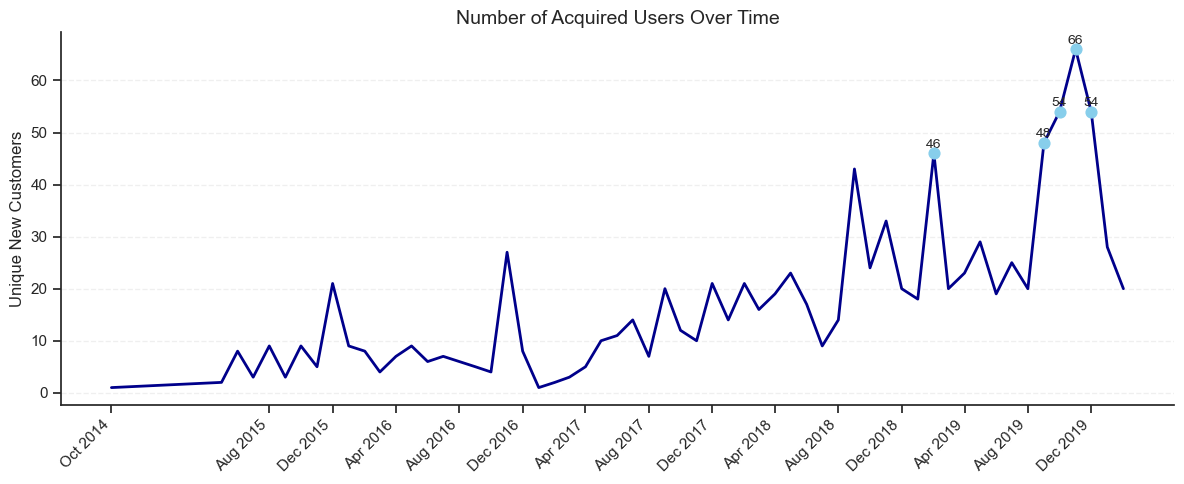

In [12]:
sns.set_theme(style="ticks")
plt.figure(figsize=(12,5))
df_over_time = df_cmr.groupby(df_cmr['date_upgr'].dt.to_period("M"))['user'].nunique()
dates = df_over_time.index.to_timestamp()
values = df_over_time.values

plt.plot(dates, values, linestyle='-', color='darkblue', linewidth=2)

# Top points
top_n = 5
top_indices = values.argsort()[-top_n:]
top_indices = top_indices[np.argsort(dates[top_indices])]  # sort by date

plt.scatter(dates[top_indices], values[top_indices], color='skyblue', s=60, zorder=5)

for i in top_indices:
    plt.text(dates[i], values[i]+0.5, str(values[i]), ha='center', va='bottom', fontsize=10)

plt.title("Number of Acquired Users Over Time", fontsize=14)
plt.ylabel("Unique New Customers", fontsize=12)
plt.xlabel("")

step = max(1, len(dates)//12)
plt.xticks(
    ticks=dates[::step],
    labels=[d.strftime('%b %Y') for d in dates[::step]],
    rotation=45,
    ha='right'
)

sns.despine(top=True, right=True)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

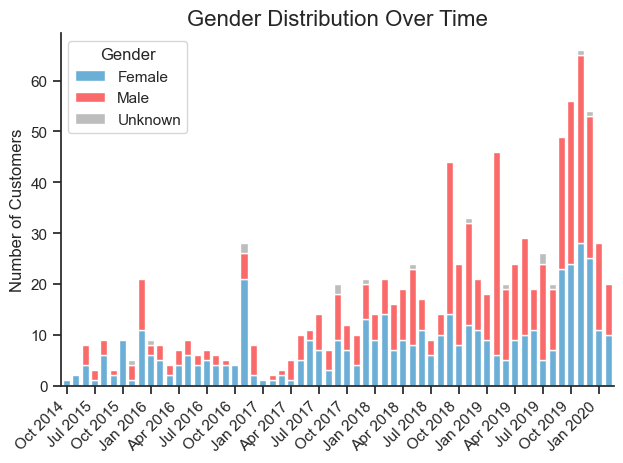

In [13]:
# Group data
df_gender_time = df_cmr.groupby([df_cmr['date_upgr'].dt.to_period("M"), 'gender'])['user'].count().unstack(fill_value=0)

# Plot setup
plt.figure(figsize=(14,7))
colors = ['#6baed6', '#fb6a6a', '#bdbdbd']  # blue, red, gray
df_gender_time.plot(kind='bar', stacked=True, width=0.75, color=colors)

# Titles & labels
plt.title("Gender Distribution Over Time", fontsize=16)
plt.xlabel("")
plt.ylabel("Number of Customers", fontsize=12)

# Show every 3rd label with month names
N = 3
xticks = range(0, len(df_gender_time), N)
xticklabels = [x.strftime('%b %Y') for x in df_gender_time.index.to_timestamp()[::N]]
plt.xticks(ticks=xticks, labels=xticklabels, rotation=45, ha='right')

# Legend
plt.legend(title='Gender', fontsize=11, title_fontsize=12)

# Clean layout
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

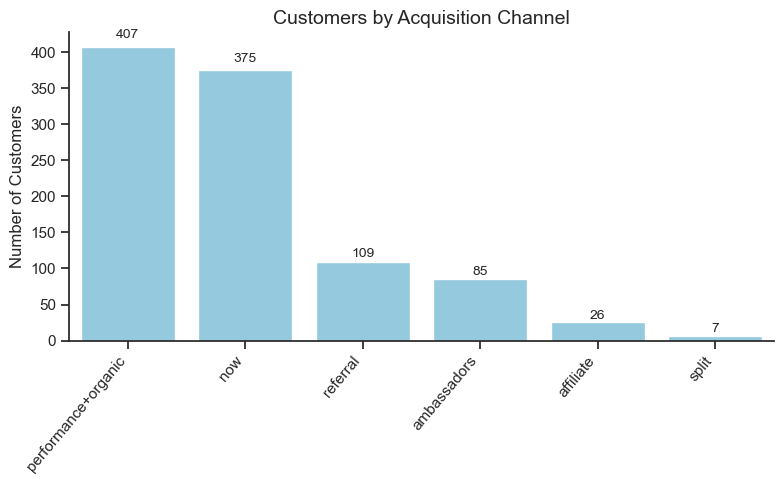

In [14]:
sns.set_theme(style="ticks")

# Count acquisition channels and sort descending
counts = df_cmr['source'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8,5))

# Single-color bars
sns.barplot(x=counts.index, y=counts.values, ax=ax, color="skyblue")

# Titles & labels
ax.set_title("Customers by Acquisition Channel", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Number of Customers", fontsize=12)

# Rotate x-axis labels safely
plt.setp(ax.get_xticklabels(), rotation=50, ha='right')

# Add count labels on top
for i, val in enumerate(counts.values):
    ax.text(i, val + val*0.02, str(val), ha='center', va='bottom', fontsize=10)

# Remove top and right spines (frames)
sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
plt.show()

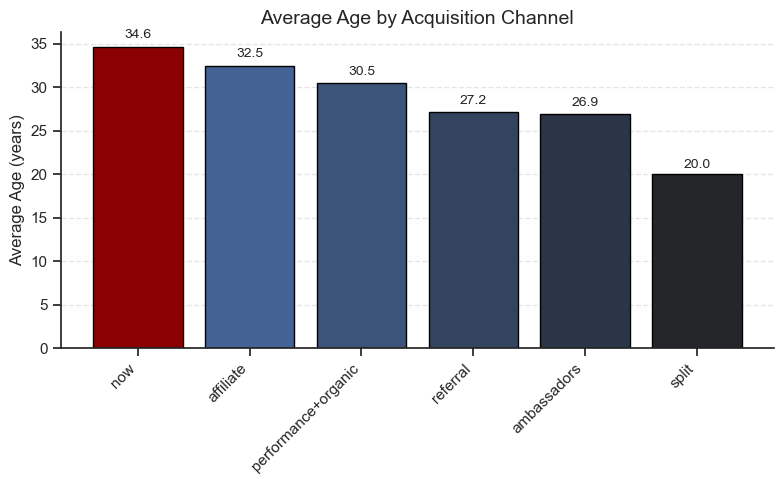

In [15]:
sns.set_theme(style="ticks")

# Calculate average age by acquisition channel and sort descending
avg_age = df_cmr.groupby('source')['age'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8,5))

# Prepare colors: highlight top bar
colors = sns.color_palette("dark:b_r", n_colors=len(avg_age))
colors[0] = "darkred"  # Highlight the top bar

# Use Matplotlib's bar function to avoid Seaborn palette warning
bars = ax.bar(avg_age.index, avg_age.values, color=colors, edgecolor='black')

# Titles & labels
ax.set_title("Average Age by Acquisition Channel", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Average Age (years)", fontsize=12)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add value labels on top
for i, val in enumerate(avg_age.values):
    ax.text(i, val + val*0.02, f"{val:.1f}", ha='center', va='bottom', fontsize=10)

# Subtle horizontal gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
plt.show()

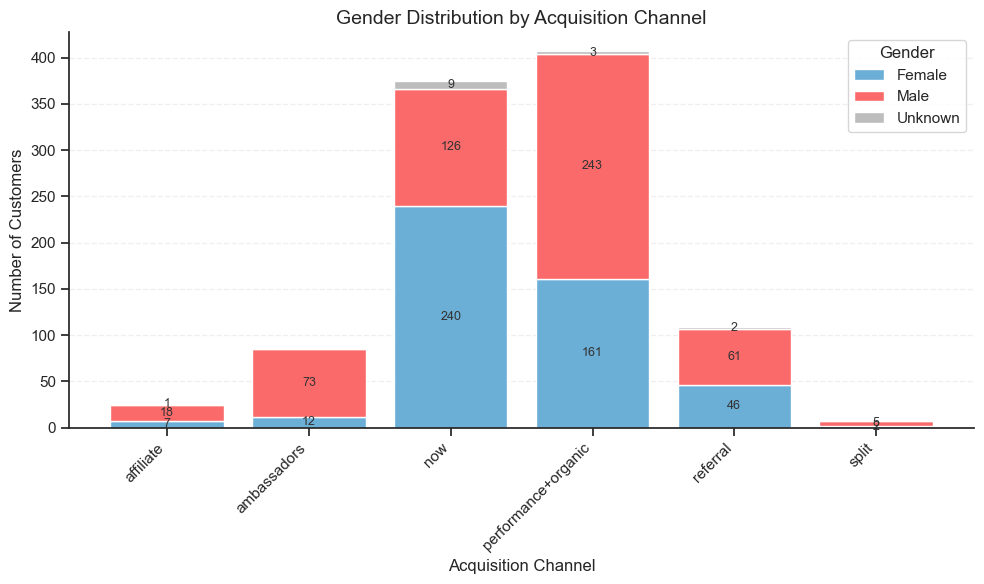

In [16]:
sns.set_theme(style="ticks")  # minimal theme

# Prepare data: counts of users by source and gender
gender_split = df_cmr.groupby(['source', 'gender'])['user'].count().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10,6))

# Define custom colors: blue, red, gray
colors = ['#6baed6', '#fb6a6a', '#bdbdbd']

# Positions for bars
x = np.arange(len(gender_split.index))

# Bottom tracker for stacking
bottom = np.zeros(len(gender_split.index))

# Plot stacked bars
for i, gender in enumerate(gender_split.columns):
    ax.bar(x, gender_split[gender], bottom=bottom, color=colors[i], edgecolor='white', label=gender)
    
    # Add counts inside each segment
    for j, val in enumerate(gender_split[gender]):
        if val > 0:
            ax.text(x[j], bottom[j] + val/2, str(val), ha='center', va='center', fontsize=9, color='#333333')
    
    # Update bottom for next stack
    bottom += gender_split[gender].values

# Titles & labels
ax.set_title("Gender Distribution by Acquisition Channel", fontsize=14)
ax.set_xlabel("Acquisition Channel", fontsize=12)
ax.set_ylabel("Number of Customers", fontsize=12)

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(gender_split.index, rotation=45, ha='right')

# Subtle horizontal gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Legend
ax.legend(title='Gender')

plt.tight_layout()
plt.show()